In [1]:
import pandas as pd
import matplotlib as plt
import numpy as np
from sklearn.tree import export_graphviz
import pydotplus
from six import StringIO 
import IPython.display as display
from PIL import Image
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 500)

## Task definition -

The goal is to predict the player rating ("Overall" field) by using other player attributes as well as to understand which of these attributes affects the player rating the most.

**Hypothesis** - different player attributes likely determine the rating for players in different position. Ex: Forward players likely need more volley skills and positioning skills compared to goalkeepers or defensive players. Goalkeepers will find goal keeping related skills such as GKDiving, GKReflexes more important than volleying or dribbling. 

Hence, if we build a separate decision tree for players in different positions, this will likely lead to a more performant model as well as a more interpretable model.

#### Goals - 
1. Developing a model that can predict the player rating accurately using the players skills and other useful attributes.
2. Developing a model that can be interpreted to provide insights into what skills affect rating the most.
3. Checking whether our hypothesis is correct.

It is important to note that the most performant models may not always be the most interpretable. Hence, we may end up with different models for each goal.

### Modeling

In [2]:
df = pd.read_csv('preproc.csv')
df

,ID,Name,Nationality,Club,Age,Height,Weight,Overall,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,precise_position,Defense,Forward,Goalkeeper,Midfield
0,158023,L. Messi,Argentina,FC Barcelona,31,5.583333,159.0,94,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,RF,0,1,0,0
1,20801,Cristiano Ronaldo,Portugal,Juventus,33,6.166667,183.0,94,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,ST,0,1,0,0
2,190871,Neymar Jr,Brazil,Paris Saint-Germain,26,5.750000,150.0,92,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,LW,0,1,0,0
3,193080,De Gea,Spain,Manchester United,27,6.333333,168.0,91,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,GK,0,0,1,0
4,192985,K. De Bruyne,Belgium,Manchester City,27,5.916667,154.0,91,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,RCM,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17913,238813,J. Lundstram,England,Crewe Alexandra,19,5.750000,134.0,47,34.0,38.0,40.0,49.0,25.0,42.0,30.0,34.0,45.0,43.0,54.0,57.0,60.0,49.0,76.0,43.0,55.0,40.0,47.0,38.0,46.0,46.0,39.0,52.0,43.0,45.0,40.0,48.0,47.0,10.0,13.0,7.0,8.0,9.0,CM,0,0,0,1
17914,243165,N. Christoffersson,Sweden,Trelleborgs FF,19,6.250000,170.0,47,23.0,52.0,52.0,43.0,36.0,39.0,32.0,20.0,25.0,40.0,41.0,39.0,38.0,40.0,52.0,41.0,47.0,43.0,67.0,42.0,47.0,16.0,46.0,33.0,43.0,42.0,22.0,15.0,19.0,10.0,9.0,9.0,5.0,12.0,ST,0,1,0,0
17915,241638,B. Worman,England,Cambridge United,16,5.666667,148.0,47,25.0,40.0,46.0,38.0,38.0,45.0,38.0,27.0,28.0,44.0,70.0,69.0,50.0,47.0,58.0,45.0,60.0,55.0,32.0,45.0,32.0,15.0,48.0,43.0,55.0,41.0,32.0,13.0,11.0,6.0,5.0,10.0,6.0,13.0,ST,0,1,0,0
17916,246268,D. Walker-Rice,England,Tranmere Rovers,17,5.833333,154.0,47,44.0,50.0,39.0,42.0,40.0,51.0,34.0,32.0,32.0,52.0,61.0,60.0,52.0,21.0,71.0,64.0,42.0,40.0,48.0,34.0,33.0,22.0,44.0,47.0,50.0,46.0,20.0,25.0,27.0,14.0,6.0,14.0,8.0,9.0,RW,0,1,0,0


In [3]:
extras = ['ID', 'Name',  'Nationality', 'Club']

y = 'Overall'

skills = [ 'Crossing', 'Finishing', 'HeadingAccuracy', 
       'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes']

xs = [ 'Defense', 'Forward', 'Goalkeeper', 'Midfield', 'Age', 'Height', 'Weight' ] + skills

In [4]:
X = df[xs].astype('float32')
X

,Defense,Forward,Goalkeeper,Midfield,Age,Height,Weight,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,0.0,1.0,0.0,0.0,31.0,5.583333,159.0,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,0.0,1.0,0.0,0.0,33.0,6.166667,183.0,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,0.0,1.0,0.0,0.0,26.0,5.750000,150.0,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,0.0,0.0,1.0,0.0,27.0,6.333333,168.0,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,0.0,0.0,0.0,1.0,27.0,5.916667,154.0,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17913,0.0,0.0,0.0,1.0,19.0,5.750000,134.0,34.0,38.0,40.0,49.0,25.0,42.0,30.0,34.0,45.0,43.0,54.0,57.0,60.0,49.0,76.0,43.0,55.0,40.0,47.0,38.0,46.0,46.0,39.0,52.0,43.0,45.0,40.0,48.0,47.0,10.0,13.0,7.0,8.0,9.0
17914,0.0,1.0,0.0,0.0,19.0,6.250000,170.0,23.0,52.0,52.0,43.0,36.0,39.0,32.0,20.0,25.0,40.0,41.0,39.0,38.0,40.0,52.0,41.0,47.0,43.0,67.0,42.0,47.0,16.0,46.0,33.0,43.0,42.0,22.0,15.0,19.0,10.0,9.0,9.0,5.0,12.0
17915,0.0,1.0,0.0,0.0,16.0,5.666667,148.0,25.0,40.0,46.0,38.0,38.0,45.0,38.0,27.0,28.0,44.0,70.0,69.0,50.0,47.0,58.0,45.0,60.0,55.0,32.0,45.0,32.0,15.0,48.0,43.0,55.0,41.0,32.0,13.0,11.0,6.0,5.0,10.0,6.0,13.0
17916,0.0,1.0,0.0,0.0,17.0,5.833333,154.0,44.0,50.0,39.0,42.0,40.0,51.0,34.0,32.0,32.0,52.0,61.0,60.0,52.0,21.0,71.0,64.0,42.0,40.0,48.0,34.0,33.0,22.0,44.0,47.0,50.0,46.0,20.0,25.0,27.0,14.0,6.0,14.0,8.0,9.0


In [5]:
X = X.drop(columns=['Reactions'])
X.shape

(17918, 40)

In [6]:
y = df[y]
y

0        94
1        94
2        92
3        91
4        91
         ..
17913    47
17914    47
17915    47
17916    47
17917    46
Name: Overall, Length: 17918, dtype: int64

**Splitting the data into training, validation and test set**

We randomly split the dataset into train, validation, and test set in a 80-10-10 split.

In [7]:
X_train, X_val, y_train, y_val =  train_test_split(X, y, test_size=0.2, random_state=5000)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((14334, 40), (3584, 40), (14334,), (3584,))

In [8]:
X_test, X_val, y_test, y_val =  train_test_split(X_val, y_val, test_size=0.5, random_state=5000)
X_test.shape, X_val.shape, y_test.shape, y_val.shape

((1792, 40), (1792, 40), (1792,), (1792,))

Run the following to install pydotplus and graphviz (required for visualization of Decision Trees) - 

```
conda install graphviz
pip install pydotplus
```

If on windows, follow these steps after the above installation (Source - https://stackoverflow.com/questions/28312534/graphvizs-executables-are-not-found-python-3-4)

```
In my case (Win10, Anaconda3, Jupyter notebook) after "conda install graphviz" I have to add to the PATH: C:\Users\username\Anaconda3\Library\bin\graphviz

To modify PATH goto Control Panel > System and Security > System > Advanced System Settings > Environment Variables > Path > Edit > New
```

In [9]:
def tree_viz(model: 'Decision Tree model', 
             class_names: 'list(str) - list of label (class) names', 
             feature_names: 'list(str) - list of names of features of the independent variable', 
             out_fname:'if specified, graph is saved to this path'=None,rotate=False) -> Image:
    dot_data = StringIO()
    export_graphviz(model, out_file=dot_data, class_names=class_names, 
     feature_names=feature_names, filled=True, rounded=True,
     special_characters=True, rotate=rotate)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
    if out_fname:
        graph.write_png(out_fname)
    return display.Image(graph.create_png())

def eval_model(model, X_train, y_train, X_val, y_val):
    R2_train, R2_val = model.score(X_train, y_train), model.score(X_val, y_val)
    MSE_train, MSE_valid = np.sqrt(mean_squared_error(y_train, model.predict(X_train))), np.sqrt(mean_squared_error(y_val, model.predict(X_val)))
    print(f'R2 train = {R2_train}')
    print(f'R2 validation = {R2_val}')
    print(f'sqrt(Mean Squared Error) train = {MSE_train}')
    print(f'sqrt(Mean Squared Error) validation  = {MSE_valid}')

We build a decision tree model because decision trees are very interpretable and don't require extra preprocessing such as feature scaling etc. Visualizing the tree can provide an interpretable, easy to use model that can be used by football managers in real life.

In [10]:
model = DecisionTreeRegressor(random_state=1234)
model.fit(X_train, y_train)
eval_model(model, X_train, y_train, X_val, y_val)

R2 train = 1.0
R2 validation = 0.8959266047327518
sqrt(Mean Squared Error) train = 0.0
sqrt(Mean Squared Error) validation  = 2.248139111417644


In [11]:
model.tree_.max_depth

28

We obtain a tree with very good performance. On average, we're off by around +- 2.25 from the correct player rating. We may be able to improve the performance with some hyperparameter tuning. The hyperparameters we consider are max_depth and max_features. max_depth controls the maximum depth of the tree whereas max_features controls the maximum number of features used by the tree (features that may cause the tree to overfit may be ignored).

In [12]:
def grid_search(X, y, param_grid=None, model_cls=DecisionTreeRegressor):
    param_grid = {'max_depth':list(range(4, 28, 1)), 'max_features':[0.5, 0.6, 0.7,0.8,0.9,1.0]} if param_grid is None else param_grid
    gs = GridSearchCV(model_cls(random_state=1234) if not (model_cls == LinearRegression or model_cls == SVR) else model_cls(), 
                      param_grid=param_grid, 
                      scoring=make_scorer(mean_squared_error, greater_is_better=False), 
                      n_jobs=-1)
    gs.fit(X, y) 
    return gs.best_estimator_, gs.best_params_, np.sqrt(-gs.best_score_)

In [13]:
param_grid = {'max_depth': [5, 7, 10, 12, 13, 15, 18, 20, 25, 30, None], 'max_features':[0.7, 0.8, 0.9, 1.0]}
model, params, score = grid_search(X_train, y_train, param_grid=param_grid, model_cls=DecisionTreeRegressor)
print(params)
np.sqrt(mean_squared_error(y_val, model.predict(X_val) ))

{'max_depth': 12, 'max_features': 0.7}


2.159765887343624

Achieves better performance than our previous model and is on average within +- 2.1597 of the correct rating. The best hyperparameters are - max_depth = 12 and max_features = 0.7.

In [15]:
def build_model_for_position(position, X, y, param_grid=None, model_cls=DecisionTreeRegressor):
    all_positions = ['Defense', 'Forward', 'Goalkeeper', 'Midfield']
    X_filtered = X[X[position] == 1.0]
    y_filtered = y[X[position] == 1.0]
    X_filtered = X_filtered.drop(columns=all_positions)
    model, best_params, best_score = grid_search(X_filtered, y_filtered, param_grid=param_grid, model_cls=model_cls)
    return {'model':model, 'params':best_params, 'score':best_score}

def build_model_for_all_positions(X, y, param_grid=None, model_cls=DecisionTreeRegressor):
    all_positions = ['Defense', 'Forward', 'Goalkeeper', 'Midfield']
    res = {}
    for pos in all_positions:
        print(f'Building model for position = {pos}')
        res[pos] = build_model_for_position(pos, X, y, param_grid=param_grid, model_cls=model_cls)
        print(f'Model built. Results = ', res[pos], '\n\n')
    return res

def position_model_predict(X, y, models):
    all_positions = ['Defense', 'Forward', 'Goalkeeper', 'Midfield']
    preds = []
    for pos in all_positions:
        X_filtered, y_filtered = X[X[pos] == 1.0], y[X[pos] == 1.0]
        X_filtered = X_filtered.drop(columns=all_positions)
        pr = pd.Series(models[pos]['model'].predict(X_filtered), index=X_filtered.index)
        preds.append(pr)
    preds = pd.concat(preds, axis=0).loc[X.index]
    return preds

In [16]:
param_grid = {'max_depth': [5, 7, 10, 12, 13, 15, 18, 20, 25, 30, None], 'max_features':[0.7, 0.8, 0.9, 1.0]}
res = build_model_for_all_positions(X_train, y_train, param_grid=param_grid)
res

Building model for position = Defense
Model built. Results =  {'model': DecisionTreeRegressor(max_depth=7, max_features=0.9, random_state=1234), 'params': {'max_depth': 7, 'max_features': 0.9}, 'score': 2.0433097102113087} 


Building model for position = Forward
Model built. Results =  {'model': DecisionTreeRegressor(max_depth=7, max_features=1.0, random_state=1234), 'params': {'max_depth': 7, 'max_features': 1.0}, 'score': 2.108385095208985} 


Building model for position = Goalkeeper
Model built. Results =  {'model': DecisionTreeRegressor(max_depth=7, max_features=0.8, random_state=1234), 'params': {'max_depth': 7, 'max_features': 0.8}, 'score': 1.59920266197598} 


Building model for position = Midfield
Model built. Results =  {'model': DecisionTreeRegressor(max_depth=10, max_features=1.0, random_state=1234), 'params': {'max_depth': 10, 'max_features': 1.0}, 'score': 2.1934642423654225} 




{'Defense': {'model': DecisionTreeRegressor(max_depth=7, max_features=0.9, random_state=1234),
  'params': {'max_depth': 7, 'max_features': 0.9},
  'score': 2.0433097102113087},
 'Forward': {'model': DecisionTreeRegressor(max_depth=7, max_features=1.0, random_state=1234),
  'params': {'max_depth': 7, 'max_features': 1.0},
  'score': 2.108385095208985},
 'Goalkeeper': {'model': DecisionTreeRegressor(max_depth=7, max_features=0.8, random_state=1234),
  'params': {'max_depth': 7, 'max_features': 0.8},
  'score': 1.59920266197598},
 'Midfield': {'model': DecisionTreeRegressor(max_depth=10, max_features=1.0, random_state=1234),
  'params': {'max_depth': 10, 'max_features': 1.0},
  'score': 2.1934642423654225}}

In [17]:
np.sqrt(mean_squared_error(y_val, position_model_predict(X_val, y_val, res) ))

2.1017239703440453

We get further performance improvements using this model!

**Visualizing the models**

It is hard to visualize models with depth 6 or more on the notebook since they contain too many leaf nodes. Hence, we build and visualize shorter trees to understand the internal working of the model.

In [18]:
param_grid = {'max_depth':[4], 'max_features':[0.5, 0.6, 0.7,0.8,0.9,1.0]}
res = build_model_for_all_positions(X_train, y_train, param_grid=param_grid)
res

Building model for position = Defense
Model built. Results =  {'model': DecisionTreeRegressor(max_depth=4, max_features=0.5, random_state=1234), 'params': {'max_depth': 4, 'max_features': 0.5}, 'score': 2.4875605297659336} 


Building model for position = Forward
Model built. Results =  {'model': DecisionTreeRegressor(max_depth=4, max_features=0.9, random_state=1234), 'params': {'max_depth': 4, 'max_features': 0.9}, 'score': 2.5202037169343754} 


Building model for position = Goalkeeper
Model built. Results =  {'model': DecisionTreeRegressor(max_depth=4, max_features=1.0, random_state=1234), 'params': {'max_depth': 4, 'max_features': 1.0}, 'score': 2.103725220003369} 


Building model for position = Midfield
Model built. Results =  {'model': DecisionTreeRegressor(max_depth=4, max_features=1.0, random_state=1234), 'params': {'max_depth': 4, 'max_features': 1.0}, 'score': 2.772768758275613} 




{'Defense': {'model': DecisionTreeRegressor(max_depth=4, max_features=0.5, random_state=1234),
  'params': {'max_depth': 4, 'max_features': 0.5},
  'score': 2.4875605297659336},
 'Forward': {'model': DecisionTreeRegressor(max_depth=4, max_features=0.9, random_state=1234),
  'params': {'max_depth': 4, 'max_features': 0.9},
  'score': 2.5202037169343754},
 'Goalkeeper': {'model': DecisionTreeRegressor(max_depth=4, max_features=1.0, random_state=1234),
  'params': {'max_depth': 4, 'max_features': 1.0},
  'score': 2.103725220003369},
 'Midfield': {'model': DecisionTreeRegressor(max_depth=4, max_features=1.0, random_state=1234),
  'params': {'max_depth': 4, 'max_features': 1.0},
  'score': 2.772768758275613}}

In [19]:
np.sqrt(mean_squared_error(y_val, position_model_predict(X_val, y_val, res) ))

2.6225279199478875

Slightly lower performance but still a very good model since it is on average within +-2.62 of the actual rating.

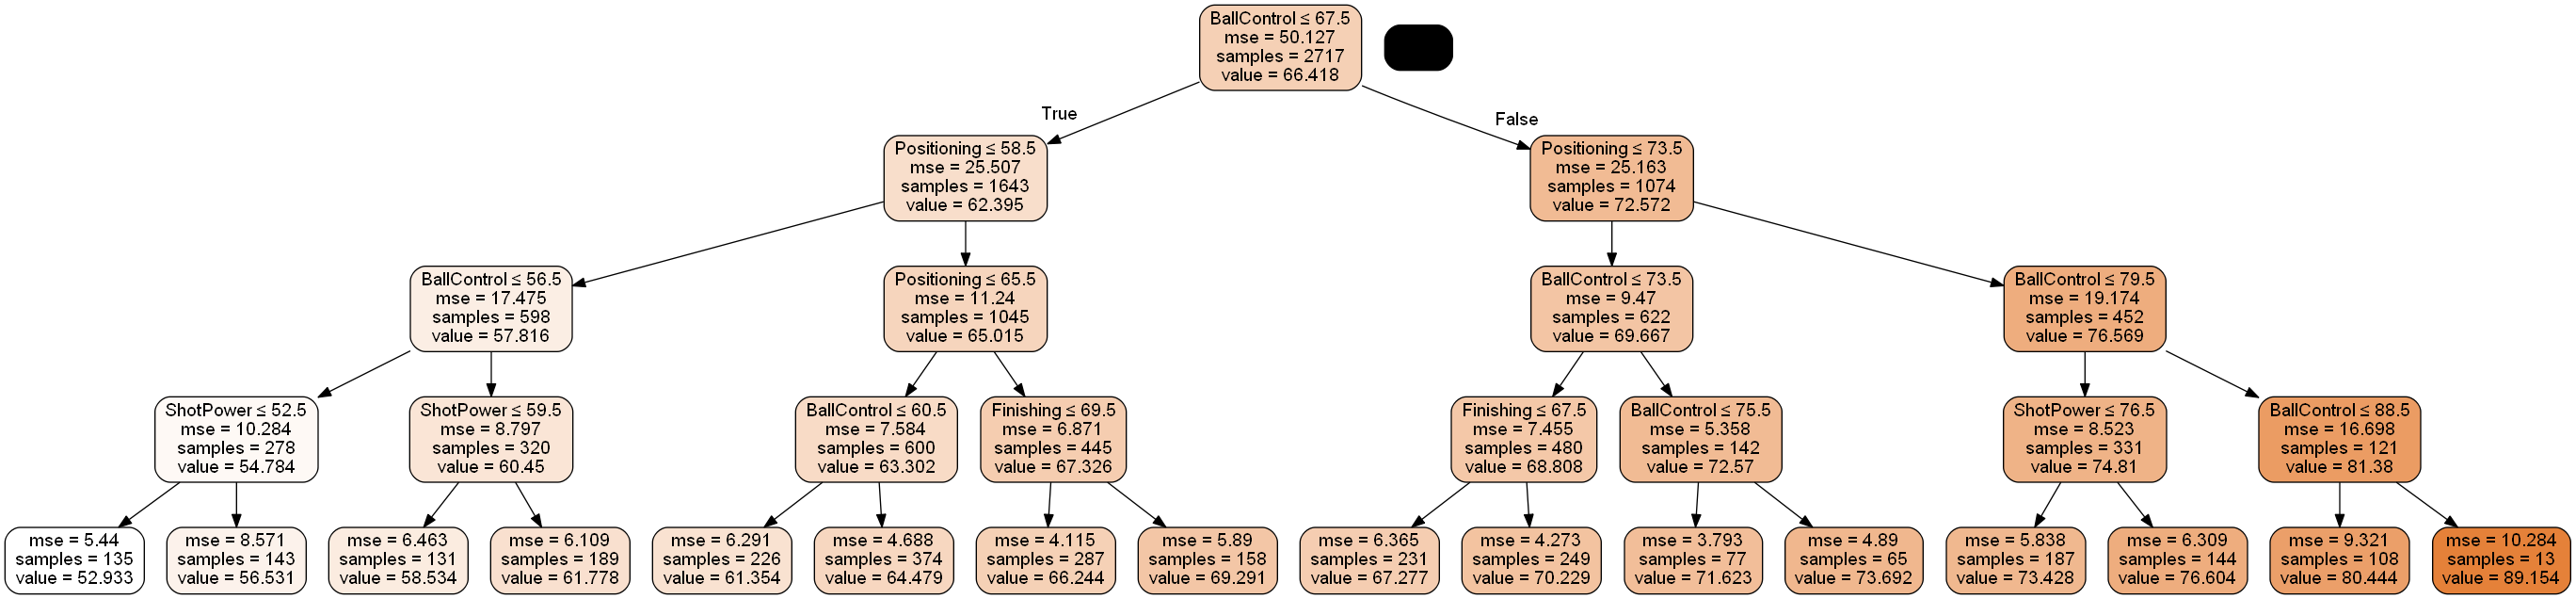

In [20]:
position = 'Forward'
model = res[position]['model']
tree_viz(model, None, X.columns[4:], f'tree_viz_{position}.png')

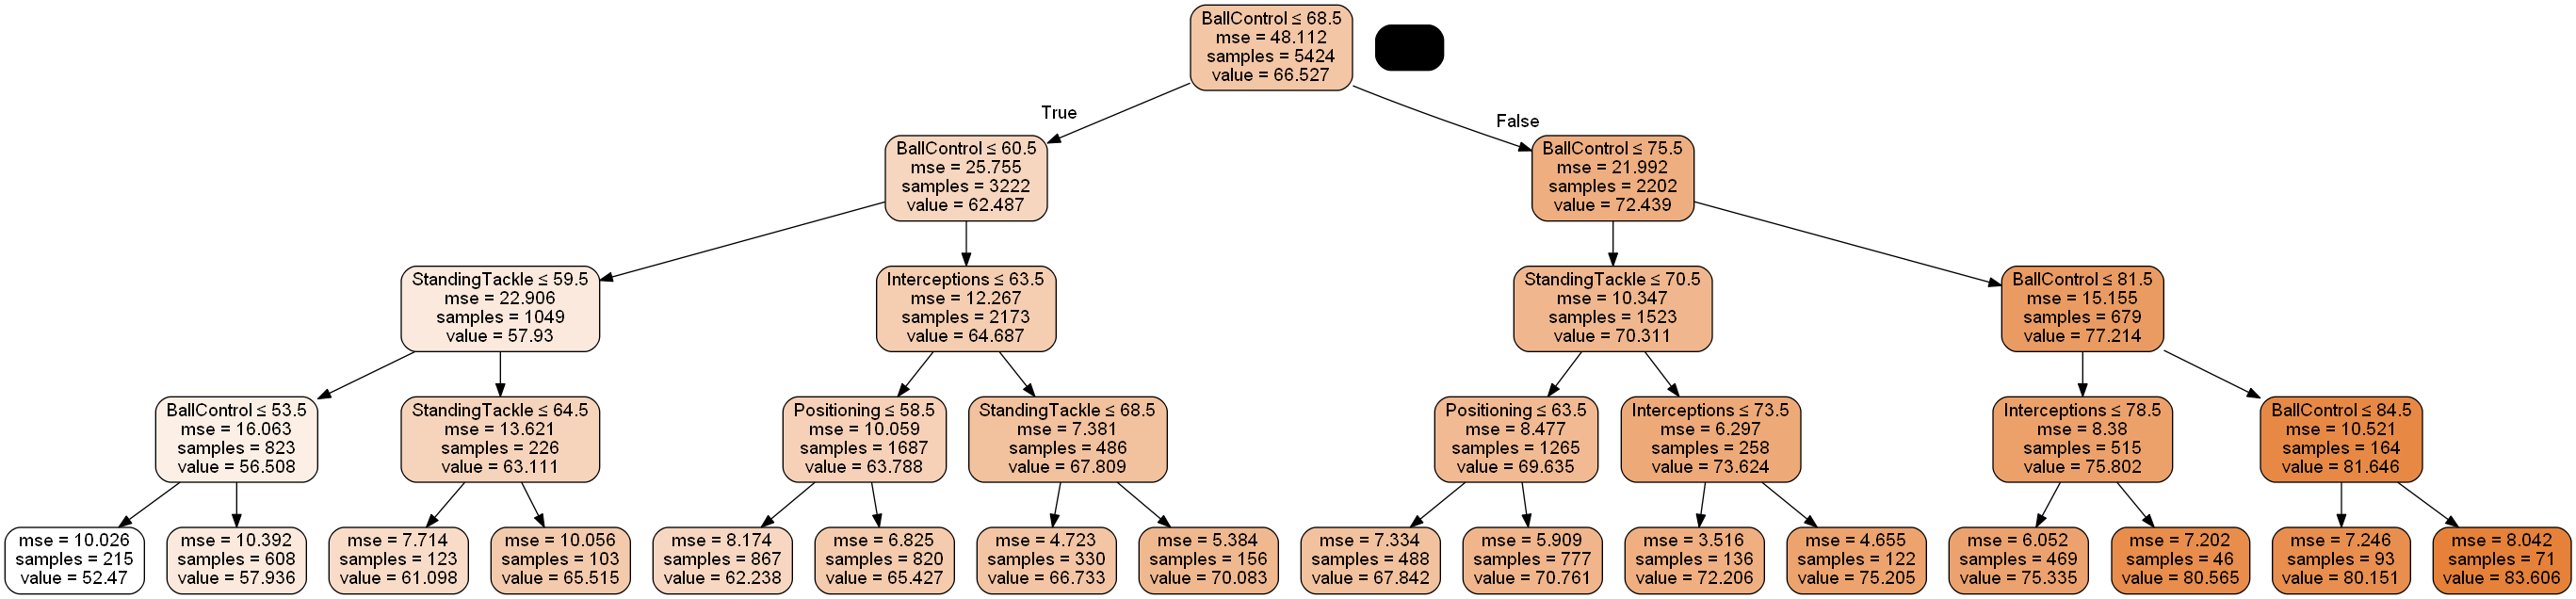

In [21]:
position = 'Midfield'
model = res[position]['model']
tree_viz(model, None, X.columns[4:], f'tree_viz_{position}.png')

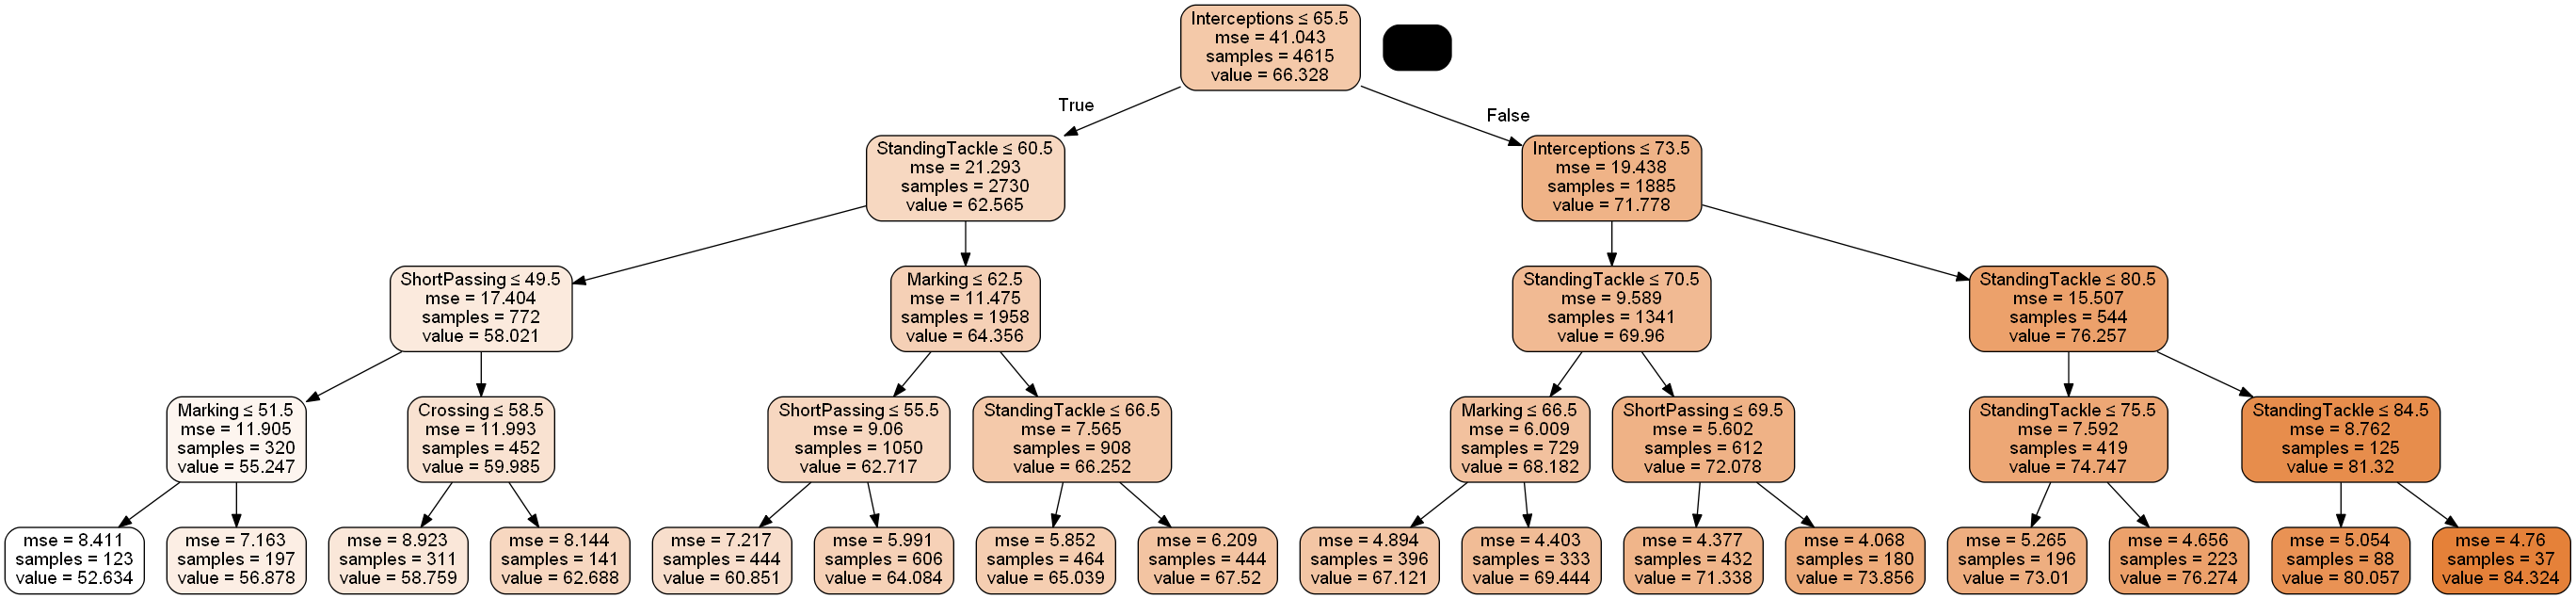

In [22]:
position = 'Defense'
model = res[position]['model']
tree_viz(model, None, X.columns[4:], f'tree_viz_{position}.png')

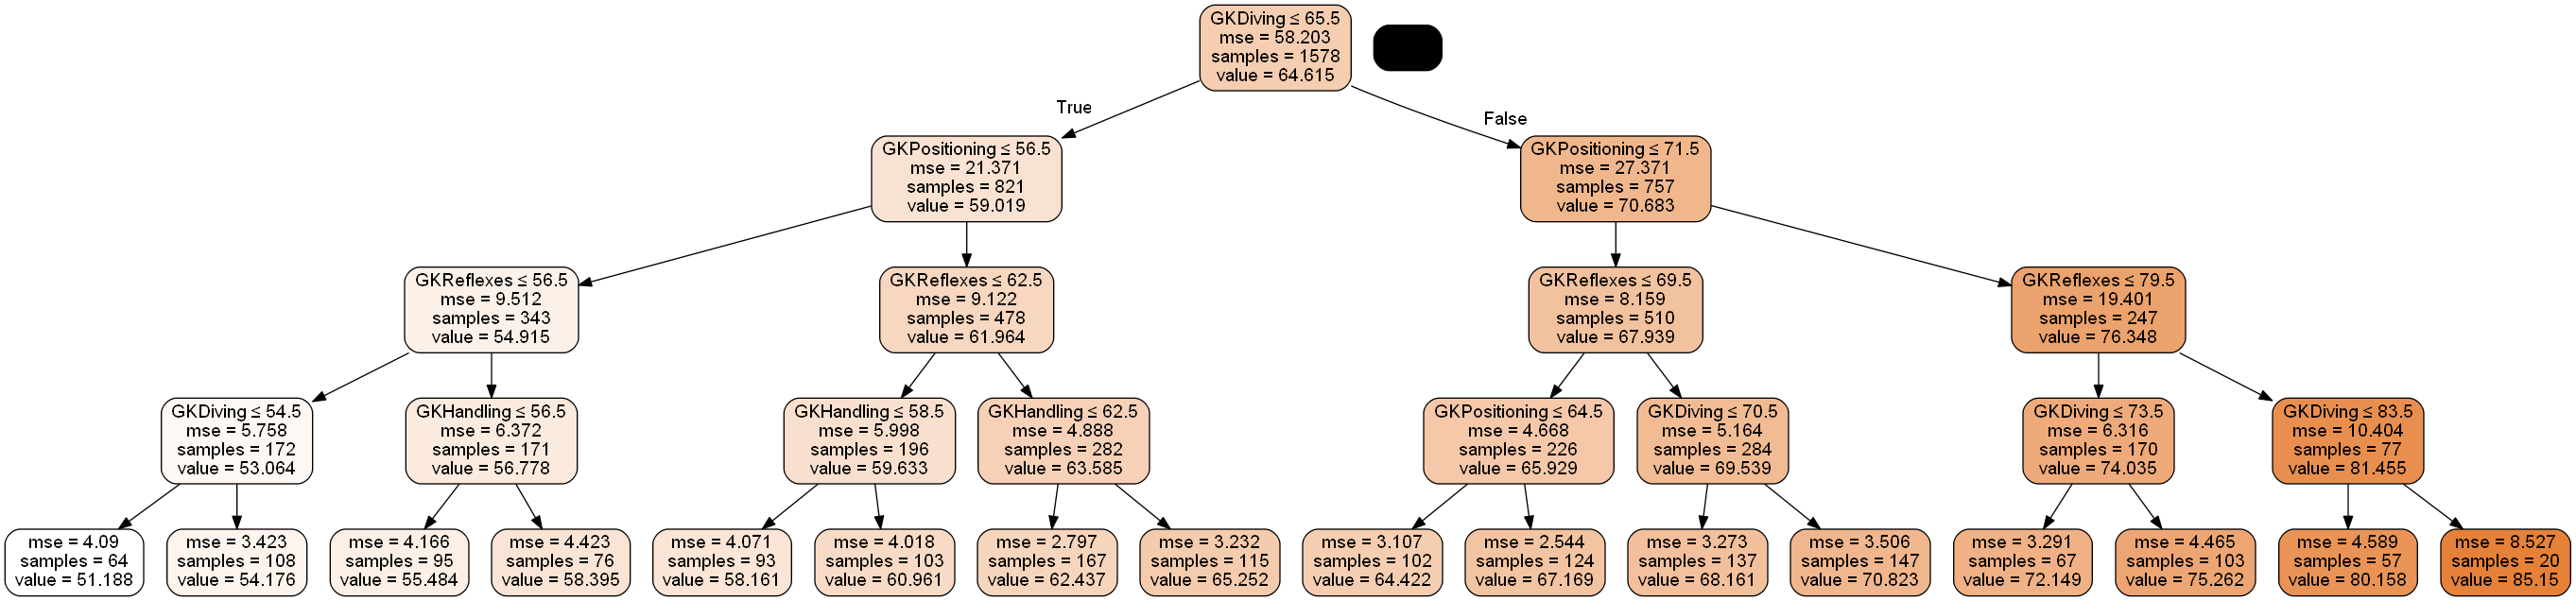

In [23]:
position = 'Goalkeeper'
model = res[position]['model']
tree_viz(model, None, X.columns[4:], f'tree_viz_{position}.png')

**Observations** 

The visualizations of the models **confirm our hypothesis** that players in different positions require different skills to have a high rating. 
* Players in Forward position require a combination of Positioning, BallControl, Finishing and ShotPower.
* Players in Midfield position require a combination of BallControl, Interceptions and Positioning.
* Players in Defense position require a combination of Interceptions, StandingTackle, Marking and ShortPassing.
* Players in Goalkeeper position require goalkeeper specific skills such as GKReflexes, GKDiving, and GKPositioning.

Building separate models for different positions also improves the performance of our rating prediction model.

### Finding the best performing model

Next, we try various different models to find the model that provides the best prediction performance (low mean squared error).

In [24]:
all_res = {}

##### **Decision Tree**

In [25]:
param_grid = {'max_depth': [5, 7, 10, 12, 13, 15, 18, 20, 25, 30, None], 'max_features':[0.7, 0.8, 0.9, 1.0]}
model, params, score = grid_search(X_train, y_train, param_grid=param_grid, model_cls=DecisionTreeRegressor)
print(params)
sqmse = np.sqrt(mean_squared_error(y_val, model.predict(X_val) ))
all_res['Decision Tree'] = [sqmse]
sqmse

{'max_depth': 12, 'max_features': 0.7}


2.159765887343624

In [26]:
param_grid = {'max_depth': [5, 7, 10, 12, 13, 15, 18, 20, 25, 30, None], 'max_features':[0.7, 0.8, 0.9, 1.0]}
res = build_model_for_all_positions(X_train, y_train, param_grid=param_grid, model_cls=DecisionTreeRegressor)
sqmse = np.sqrt(mean_squared_error(y_val, position_model_predict(X_val, y_val, res) ))
all_res['Decision Tree'].append(sqmse)
sqmse

Building model for position = Defense
Model built. Results =  {'model': DecisionTreeRegressor(max_depth=7, max_features=0.9, random_state=1234), 'params': {'max_depth': 7, 'max_features': 0.9}, 'score': 2.0433097102113087} 


Building model for position = Forward
Model built. Results =  {'model': DecisionTreeRegressor(max_depth=7, max_features=1.0, random_state=1234), 'params': {'max_depth': 7, 'max_features': 1.0}, 'score': 2.108385095208985} 


Building model for position = Goalkeeper
Model built. Results =  {'model': DecisionTreeRegressor(max_depth=7, max_features=0.8, random_state=1234), 'params': {'max_depth': 7, 'max_features': 0.8}, 'score': 1.59920266197598} 


Building model for position = Midfield
Model built. Results =  {'model': DecisionTreeRegressor(max_depth=10, max_features=1.0, random_state=1234), 'params': {'max_depth': 10, 'max_features': 1.0}, 'score': 2.1934642423654225} 




2.1017239703440453

##### **Support Vector Machine**

In [27]:
param_grid = {'kernel':['linear','rbf'], 'C': [0.01, 0.1, 1. , 10.,]}
model, params, score = grid_search(X_train, y_train, param_grid=param_grid, model_cls=SVR)
print(params)
sqmse = np.sqrt(mean_squared_error(y_val, model.predict(X_val) ))
all_res['Support Vector Machine'] = [sqmse]
sqmse

{'C': 10.0, 'kernel': 'rbf'}


1.0872701831006286

In [28]:
param_grid = {'kernel':['linear','rbf'], 'C': [0.01, 0.1, 1. , 10.,]}
res = build_model_for_all_positions(X_train, y_train, param_grid=param_grid, model_cls=SVR)
sqmse = np.sqrt(mean_squared_error(y_val, position_model_predict(X_val, y_val, res) ))
all_res['Support Vector Machine'].append(sqmse)
sqmse

Building model for position = Defense
Model built. Results =  {'model': SVR(C=10.0), 'params': {'C': 10.0, 'kernel': 'rbf'}, 'score': 0.8658998500628244} 


Building model for position = Forward
Model built. Results =  {'model': SVR(C=10.0), 'params': {'C': 10.0, 'kernel': 'rbf'}, 'score': 0.8571172494694596} 


Building model for position = Goalkeeper
Model built. Results =  {'model': SVR(C=0.01, kernel='linear'), 'params': {'C': 0.01, 'kernel': 'linear'}, 'score': 0.7082975760571687} 


Building model for position = Midfield
Model built. Results =  {'model': SVR(C=10.0), 'params': {'C': 10.0, 'kernel': 'rbf'}, 'score': 1.0268934236932532} 




0.9475047267012209

##### **Random Forest**

In [29]:
param_grid = {'n_estimators':[10, 100, 200], 'max_depth': [10, 20, 30, None], 'max_features':['auto', 0.7, 0.8, 0.9]}
model, params, score = grid_search(X_train, y_train, param_grid=param_grid, model_cls=RandomForestRegressor)
print(params)
sqmse = np.sqrt(mean_squared_error(y_val, model.predict(X_val) ))
all_res['Random Forest'] = [sqmse]
sqmse

{'max_depth': 30, 'max_features': 0.7, 'n_estimators': 200}


1.2931187834798654

In [30]:
param_grid = {'n_estimators':[10, 100, 200], 'max_depth': [10, 20, 30, None], 'max_features':['auto', 0.7, 0.8, 0.9]}
res = build_model_for_all_positions(X_train, y_train, param_grid=param_grid, model_cls=RandomForestRegressor)
sqmse = np.sqrt(mean_squared_error(y_val, position_model_predict(X_val, y_val, res) ))
all_res['Random Forest'].append(sqmse)
sqmse

Building model for position = Defense
Model built. Results =  {'model': RandomForestRegressor(max_depth=30, max_features=0.7, n_estimators=200,
                      random_state=1234), 'params': {'max_depth': 30, 'max_features': 0.7, 'n_estimators': 200}, 'score': 1.1713943525320991} 


Building model for position = Forward
Model built. Results =  {'model': RandomForestRegressor(max_depth=30, max_features=0.7, n_estimators=200,
                      random_state=1234), 'params': {'max_depth': 30, 'max_features': 0.7, 'n_estimators': 200}, 'score': 1.287992437751875} 


Building model for position = Goalkeeper
Model built. Results =  {'model': RandomForestRegressor(max_depth=10, max_features=0.7, n_estimators=200,
                      random_state=1234), 'params': {'max_depth': 10, 'max_features': 0.7, 'n_estimators': 200}, 'score': 0.9193175253238588} 


Building model for position = Midfield
Model built. Results =  {'model': RandomForestRegressor(max_depth=20, max_features=0.7, n_es

1.254953413931677

##### **Linear Regression**

In [31]:
param_grid = {'normalize':[True, False], 'fit_intercept': [True, False]}
model, params, score = grid_search(X_train, y_train, param_grid=param_grid, model_cls=LinearRegression)
print(params)
sqmse = np.sqrt(mean_squared_error(y_val, model.predict(X_val) ))
all_res['Linear Regression'] = [sqmse]
sqmse

{'fit_intercept': True, 'normalize': False}


2.912649757204431

In [32]:
param_grid = {'normalize':[True, False], 'fit_intercept': [True, False]}
res = build_model_for_all_positions(X_train, y_train, param_grid=param_grid, model_cls=LinearRegression)
sqmse = np.sqrt(mean_squared_error(y_val, position_model_predict(X_val, y_val, res) ))
all_res['Linear Regression'].append(sqmse)
sqmse

Building model for position = Defense
Model built. Results =  {'model': LinearRegression(), 'params': {'fit_intercept': True, 'normalize': False}, 'score': 1.3980925492813585} 


Building model for position = Forward
Model built. Results =  {'model': LinearRegression(), 'params': {'fit_intercept': True, 'normalize': False}, 'score': 1.1954956715879936} 


Building model for position = Goalkeeper
Model built. Results =  {'model': LinearRegression(fit_intercept=False, normalize=True), 'params': {'fit_intercept': False, 'normalize': True}, 'score': 0.7057848639374845} 


Building model for position = Midfield
Model built. Results =  {'model': LinearRegression(normalize=True), 'params': {'fit_intercept': True, 'normalize': True}, 'score': 1.952654770256571} 




1.521784272986427

### Results

The results of various models under both the normal setting as well as the setting where different models are developed for players in different position and then combined (let's call this the "PositionStacked" approach) are shown below - 

In [33]:
res = pd.DataFrame(all_res).transpose()
res.columns = ['Normal', 'Position Stacked']
res['gains'] = res['Normal'] - res['Position Stacked']
res

,Normal,Position Stacked,gains
Decision Tree,2.159766,2.101724,0.058042
Support Vector Machine,1.087270,0.947505,0.139765
Random Forest,1.293119,1.254953,0.038165
Linear Regression,2.912650,1.521784,1.390865


### Test set score

We retrain the best model using the best hyperparameters on both the training and validation set and perform the evaluation on the test set to get the final model evaluation.

In [34]:
X, y = pd.concat((X_train, X_val), axis=0), pd.concat((y_train, y_val), axis=0)
X.shape, y.shape

((16126, 40), (16126,))

In [35]:
param_grid = {'kernel':['linear','rbf'], 'C': [0.01, 10.,]}
res = build_model_for_all_positions(X, y, param_grid=param_grid, model_cls=SVR)
sqmse = np.sqrt(mean_squared_error(y_test, position_model_predict(X_test, y_test, res) ))
sqmse

Building model for position = Defense
Model built. Results =  {'model': SVR(C=10.0), 'params': {'C': 10.0, 'kernel': 'rbf'}, 'score': 0.8642189783640765} 


Building model for position = Forward
Model built. Results =  {'model': SVR(C=10.0), 'params': {'C': 10.0, 'kernel': 'rbf'}, 'score': 0.8383548893960069} 


Building model for position = Goalkeeper
Model built. Results =  {'model': SVR(C=0.01, kernel='linear'), 'params': {'C': 0.01, 'kernel': 'linear'}, 'score': 0.7079564714923365} 


Building model for position = Midfield
Model built. Results =  {'model': SVR(C=10.0), 'params': {'C': 10.0, 'kernel': 'rbf'}, 'score': 1.0361872249785} 




0.9137411228320501

The sqrt(Mean Squared Error) on the test set is **0.9137**

**Conclusions**

* Support Vector Machine with the Position Stacked approach provides the best predictive performance and is off by the correct score by just 0.9137 on average.
* Developing different models for players in different positions and combining each model to get the final prediction helped improve the performance of all models. It drastically improved the performance of Linear Regression model.
* Our hypothesis that players in different positions require different skills to have a high rating is confirmed to be correct through our analysis. Not only does splitting up the models per position improve performance, it also leads to interpretable results in Decision Trees that make intuitive sense. We clearly observe by visualizing the Decision Trees that players in different positions require different skills to have a high rating. 